In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyedflib as plib
from pyedflib import highlevel

import scipy.io
import scipy.signal

import os

Importando dados:
```txt
Seizure n 1
File name: PN00-1.edf
Registration start time: 19.39.33
Registration end time:  20.22.58
Seizure start time: 19.58.36
Seizure end time: 19.59.46
Data Sampling Rate: 512 Hz
```


In [2]:
# defining a function to filter the data using a bandpass filter
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

using the siena scalp database here

(29, 168000)
(168000, 29)
Index(['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3',
       'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9',
       'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4',
       'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2',
       'EEG Cp6', 'EEG F10'],
      dtype='object')


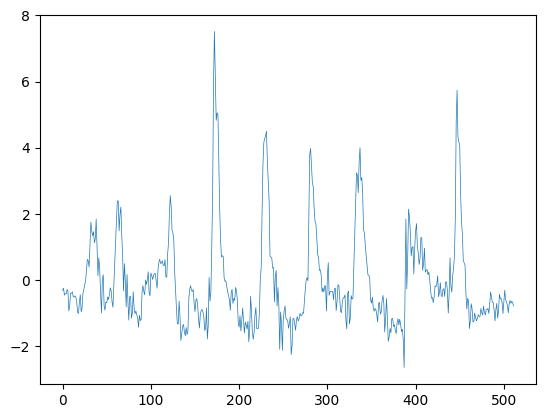

In [3]:
# Load the data
data, data_headers, header = highlevel.read_edf('./datapoints/PN00/PN00-1.edf')
print(data.shape)
# print(data_headers)

# filtering only the first 29 channels, which are EEG
df = pd.DataFrame(data[:29].T, columns=[a['label'] for a in data_headers[:29]])
print(df.shape)
# print(header)
print(df.columns)

plt.plot(df['EEG Fp1'][:512], linewidth=0.5)
plt.show()

In [ ]:
import seaborn as sns
pal = sns.color_palette()
g = sns.FacetGrid(df, aspect=15, height=.5, palette=pal)
g.map(plt.plot, 'x', 'y')
g.map(plt.axhline, y=0, lw=2, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

In [4]:
# filtering the data for 32Hz and below frequencies
filt_df = pd.DataFrame(bandpass(df.T, [0.5, 25], 512).T, columns=df.columns)

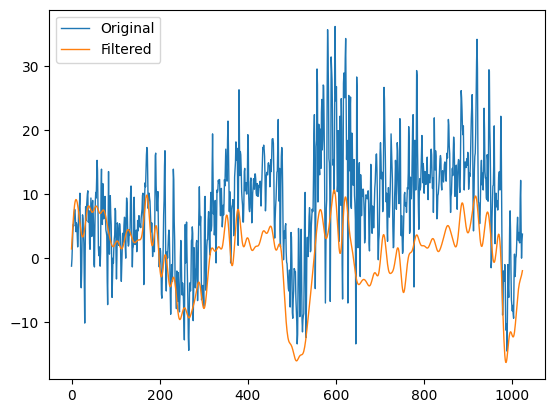

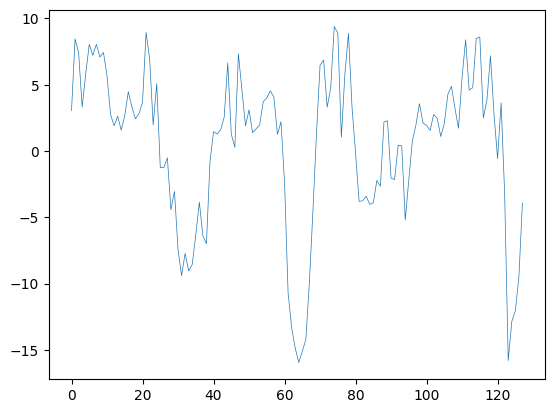

In [25]:
# applying the filter to the data
# displaying 1 sec of the filtered data
plt.plot(df['EEG Fz'][:1024], label='Original', linewidth=1)
plt.plot(filt_df['EEG Fz'][:1024], label='Filtered', linewidth=1)
plt.legend()
plt.show()

# downsampling the data to 64Hz
original_fs = 512  # Original sampling frequency in Hz
new_fs = 64  # New sampling frequency in Hz
new_length = int(len(filt_df) * (new_fs / original_fs))

# Resample the time series data
downsampled_df = pd.DataFrame(scipy.signal.resample(filt_df, new_length), columns=filt_df.columns)

# displaying 2 sec of the downsampled data
plt.plot(downsampled_df['EEG Fz'][:128], label='Filtered', linewidth=0.5)

(168000, 29)


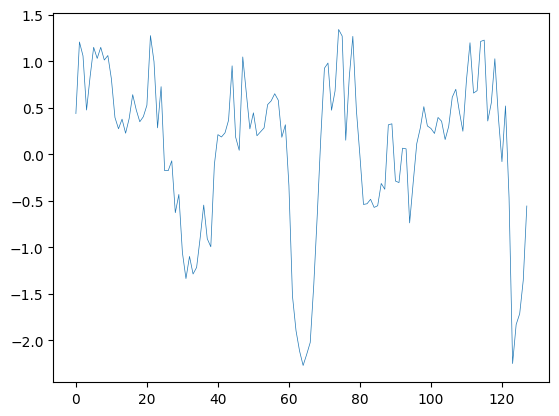

In [24]:
# normalizing the data
norm_df = (downsampled_df - downsampled_df.mean()) / downsampled_df.std()
print(norm_df.shape)

# displaying 1 sec of the normalized data
plt.plot(norm_df['EEG Fz'][:128], label='Normalized', linewidth=0.5)
plt.show()

In [31]:
# saving the downsampled data to csv files
# Define EDF file and header
edf_file = 'PN00-1.norm.edf'
channel_labels = norm_df.columns.tolist()
n_channels = len(channel_labels)
sfreq = 64  # Example sampling frequency, adjust as needed

def is_file_open(file_path):
    try:
        with open(file_path, 'r+'):
            return False
    except IOError:
        return True

# Initialize the header
if not is_file_open(edf_file):
    with plib.EdfWriter(
    edf_file,
    n_channels=n_channels,
    file_type=plib.FILETYPE_EDFPLUS
    ) as header:
        # Define channel information
        channel_info = []
        for label in channel_labels:
            chan_dict = {
                'label': label,
                'sample_rate': sfreq,
                'dimension': 'uV',
                'physical_min': df[label].min(),  # Adjusted to actual data range
                'physical_max': df[label].max(),  # Adjusted to actual data range
                'digital_min': -32768,
                'digital_max': 32767,
                'transducer': '',
                'prefilter': ''
            }
            channel_info.append(chan_dict)

        header.setSignalHeaders(channel_info)

        # Write data to EDF file
        header.writeSamples(norm_df.values.T)

print(os.path.getsize('PN00-1.norm.edf') / 1024 / 1024)  # File size in MB

/home/grey/.local/lib/python3.10/site-packages/pyedflib/edfwriter.py:124: UserWarning: Physical minimum for channel 4 (EEG O1) is -1187.375, which has 9 chars, however, EDF+ can only save 8 chars, will be truncated to -1187.37, some loss of precision is to be expected
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '\
/home/grey/.local/lib/python3.10/site-packages/pyedflib/edfwriter.py:844: UserWarning: signals are in Fortran order. Will automatically transfer to C order for compatibility with edflib.
  warnings.warn('signals are in Fortran order. Will automatically '


9.58555793762207


(29, 168000)
{'technician': '', 'recording_additional': '', 'patientname': 'X', 'patient_additional': '', 'patientcode': '', 'equipment': '', 'admincode': '', 'sex': '', 'startdate': datetime.datetime(2024, 6, 26, 0, 24, 23), 'birthdate': '', 'gender': '', 'annotations': []}
(168000, 29)


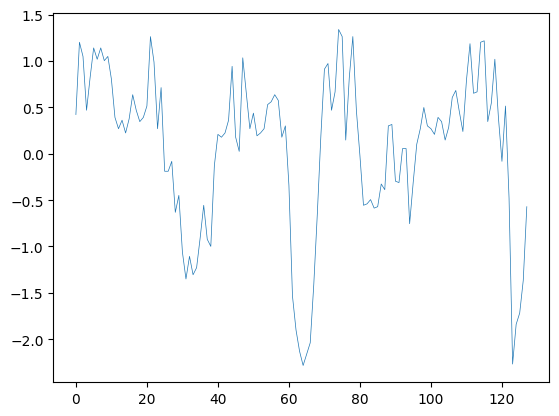

In [32]:
# trying to read the saved file
data, data_headers, header = highlevel.read_edf('PN00-1.norm.edf')
print(data.shape)
# print(data_headers)
print(header)
df2 = pd.DataFrame(data.T, columns=[a['label'] for a in data_headers])
print(df2.shape)

# displaying 1 sec of the downsampled data
plt.plot(df2['EEG Fz'][:128], label='Normalized', linewidth=0.5)
plt.show()